In [24]:
!bash -c 'source activate tl-detect && conda install -qy -c conda-forge keras scikit-learn'

Solving environment: ...working... done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.0

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /opt/conda/envs/tl-detect

  added / updated specs: 
    - keras
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    h5py-2.7.1                 |           py35_2         3.9 MB  conda-forge
    keras-2.1.5                |           py35_0         498 KB  conda-forge
    pygpu-0.7.5                |           py35_0         1.4 MB  conda-forge
    mako-1.0.7                 |           py35_0         115 KB  conda-forge
    scipy-1.0.1                |py35_blas_openblas_200        39.4 MB  conda-forge
    markupsafe-1.0             |           py35_0          32 KB  conda-forge
    theano-1.0.1               |          

In [29]:
!cat ~/.keras/keras.json

{
    "backend": "tensorflow",
    "image_data_format": "channels_last",
    "epsilon": 1e-07,
    "floatx": "float32"
}

In [1]:
!cp -R ../imgs/training/bosch/Green ../imgs/training/ && cp -R ../imgs/training/bosch/Red ../imgs/training/ && cp -R ../imgs/training/bosch/Yellow ../imgs/training/  && mv ../imgs/training/bosch ../imgs/bosch_tl 

In [2]:
! cd ../imgs/training && find . -size 0 -exec rm {} \;

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
# Visualizations will be shown in the notebook.
%matplotlib inline

In [35]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import keras



In [4]:
UNKNOWN = 4
GREEN = 2
YELLOW = 1
RED = 0

In [5]:
import cv2
import os
import numpy as np
import logging
import pandas as pd


In [6]:
import tensorflow as tf

In [7]:
# dimensions of our images.
img_width, img_height = 76, 40


def read_img(img_path, dim, colspace = 'BGR'):
    if colspace != 'GRAY':
        img = cv2.imread(img_path)
    if img is None:
        raise ValueError('Couldn\'t read img: ' + img_path)
    if colspace == 'HSV':
        logging
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
    return cv2.resize(img, dim, interpolation=cv2.INTER_CUBIC)

def read_color(path, color, dim, colspace):
    x = np.stack([read_img(path + f, dim, colspace) for f in os.listdir(path)], axis=0)
    y = np.full(x.shape[0], color)
    p = np.stack([f for f in os.listdir(path)])
    return (x, y, p)

def read_tl_dir(path, dim, colspace, lib='keras'):
    x = []
    y = []
    p = []
    for directory, color in zip(['Red/', 'Yellow/', 'Green/'], [RED, YELLOW, GREEN]): 
        x_img, y_img, f_path = read_color(os.path.join(path, directory), color, dim, colspace)
        x.append(x_img)
        y.append(y_img)
        p.append(f_path)
    
    x = np.concatenate(x)
    y = np.concatenate(y)
    p = np.concatenate(p)
    x = x.astype('float32')
    x /= 255
    return x, y, p
    

def read_train_test_tl(train_path, test_path, dim, colspace, lib='keras'):
    x_train, y_train, p_train = read_tl_dir(train_path, dim, colspace, lib)
    x_test, y_test, p_test = read_tl_dir(test_path, dim, colspace, lib)

    return x_train, y_train, p_train, x_test, y_test, p_test


train_data_dir = '../imgs/training/'
validation_data_dir = '../imgs/validation/'

x_train, y_train, p_train, x_validation, y_validation, p_validation = read_train_test_tl(train_data_dir, 
                                                                                         validation_data_dir, 
                                                                                         dim=(img_height, img_width),
                                                                                         colspace='HSV', lib='tf')

assert x_train.shape != x_validation.shape
assert x_train.shape[1:] == x_validation.shape[1:]

In [8]:
x = np.concatenate([x_train, x_validation])
y = np.concatenate([y_train, y_validation])
p = np.concatenate([p_train, p_validation])

#### Normalize images

In [9]:
def normalize_img(imgs):
    img_mean = []
    img_std = []
    for ch in range(3):
        img_mean.append(imgs[..., ch].mean())
        img_std.append(imgs[..., ch].std())
    
    imgs_corr = np.copy(imgs)
    for ch in range(3):
        imgs_corr[..., ch] = (imgs[..., ch] - img_mean[ch]) / (img_std[ch] + 1e-8)
        
    return imgs_corr

x_norm = normalize_img(x)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/conda/envs/tl-detect/lib/python3.5/site-packages/matplotlib/cm.py:259: RuntimeWarning: invalid value encountered in multiply
  xx = (xx * 255).astype(np.uint8)


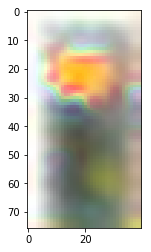

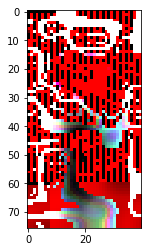

#### Balancedness
Check whether our dataset is balanced

In [10]:
pd.Categorical(y).describe()

,counts,freqs
categories,,
0,2866,0.351053
1,503,0.061612
2,4795,0.587335


4774

In [13]:
import cv2

def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis=2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype=np.float32)
    return gaussian_noise_imgs

In [14]:
def translate_imgs(X_imgs):
    translated_imgs = []
    rows, cols, _ = X_imgs[0].shape

    for X_img in X_imgs:
        M = np.float32([[1, 0, np.random.randint(-5,5)], [0, 1, np.random.randint(-5,5)]])
        translated_imgs.append(cv2.warpAffine(X_img, M, (cols, rows)))
    translated_imgs = np.array(translated_imgs, dtype=np.float32)
    return translated_imgs

def rotate_imgs(X_imgs):
    rotated_imgs = []
    rows, cols, _ = X_imgs[0].shape

    for X_img in X_imgs:
        M = cv2.getRotationMatrix2D((cols/2,rows/2), np.random.randint(-15, 15), 1)
        rotated_imgs.append(cv2.warpAffine(X_img, M, (cols, rows)))
    rotated_imgs = np.array(rotated_imgs, dtype=np.float32)
    return rotated_imgs



In [15]:
def augment_data(X_imgs, label, target_amount=5000):
    np.random.seed(seed=42)
    x_mod = []
    y_mod = []
    for col in [RED, GREEN, YELLOW]:
        aug_idx = np.random.choice(range(X_imgs[label==col].shape[0]), target_amount)
        col_mod = add_gaussian_noise(X_imgs[label==col][aug_idx])
        col_mod = translate_imgs(col_mod)
        x_mod.append(rotate_imgs(col_mod))
        y_mod.append(np.full(target_amount, col))

    x_mod = np.concatenate(x_mod)
    y_mod = np.concatenate(y_mod)
    
    return x_mod, y_mod

x_mod, y_mod = augment_data(x, y)
x_norm_mod, y_norm_mod = augment_data(x_norm, y)

In [16]:
pd.Categorical(y_mod).describe()

,counts,freqs
categories,,
0,5000,0.333333
1,5000,0.333333
2,5000,0.333333


1

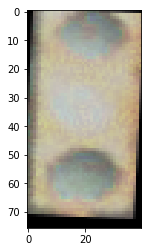

In [17]:
idx =13000
plt.imshow(hsv_to_rgb(x_mod[idx]))
y_mod[idx]

In [18]:
x_train.shape[1:]

(76, 40, 3)

In [19]:
batch_size = 1000
epochs = 25

In [40]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_width, img_height)
    x_validation = x_validation.reshape(x_validation.shape[0], 3, img_width, img_height)
    input_shape = (3, img_width, img_heigth)
else:
    x_train = x_train.reshape(x_train.shape[0], img_width, img_height, 3)
    x_validation = x_validation.reshape(x_validation.shape[0], img_width, img_height, 3)
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_validation, y_validation))
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
model.save_weights('first_try.h5')

Train on 7246 samples, validate on 7246 samples
Epoch 1/25
7246/7246 [==============================] - 5s 684us/step - loss: 1.1979 - acc: 0.4510 - val_loss: 0.7744 - val_acc: 0.7755
Epoch 2/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.7130 - acc: 0.7219 - val_loss: 0.6096 - val_acc: 0.7804
Epoch 3/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.6191 - acc: 0.7773 - val_loss: 0.5728 - val_acc: 0.7875
Epoch 4/25
7246/7246 [==============================] - 4s 617us/step - loss: 0.5993 - acc: 0.7811 - val_loss: 0.5893 - val_acc: 0.7833
Epoch 5/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.6021 - acc: 0.7815 - val_loss: 0.5696 - val_acc: 0.7872
Epoch 6/25
7246/7246 [==============================] - 4s 616us/step - loss: 0.5863 - acc: 0.7876 - val_loss: 0.5591 - val_acc: 0.7890
Epoch 7/25
7246/7246 [==============================] - 4s 617us/step - loss: 0.5933 - acc: 0.7861 - val_loss: 0.5569 - val_acc: 0.7893


In [25]:
from sklearn.utils import shuffle
x_mod, y_mod = shuffle(x_mod, y_mod)


(15000, 76, 40, 3)

In [43]:
# Training Parameters
learning_rate = 0.0005
num_steps = 8000
batch_size = 128

# Network Parameters
num_input = x.shape[0] 
num_classes = 3 
dropout = 0.5 # Dropout, probability to drop a unit

def create_new_conv_layer(input_data, num_input_channels, num_filters, filter_shape, pool_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels, num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03), name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

    # add the bias
    out_layer += bias

    # apply a ReLU non-linear activation
    out_layer = tf.nn.relu(out_layer)

    # now perform max pooling
    # ksize is the argument which defines the size of the max pooling window (i.e. the area over which the maximum is
    # calculated).  It must be 4D to match the convolution - in this case, for each image we want to use a 2 x 2 area
    # applied to each channel
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    # strides defines how the max pooling area moves through the image - a stride of 2 in the x direction will lead to
    # max pooling areas starting at x=0, x=2, x=4 etc. through your image.  If the stride is 1, we will get max pooling
    # overlapping previous max pooling areas (and no reduction in the number of parameters).  In this case, we want
    # to do strides of 2 in the x and y directions.
    strides = [1, 2, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, padding='SAME')

    return out_layer

def conv_net(input_data, dropout, reuse, is_training):
    with tf.variable_scope('ConvNet', reuse=reuse):
        input2d = tf.reshape(input_data, [-1, img_height, img_width, 3])
        
        # create some convolutional layers
        conv1 = create_new_conv_layer(input2d, 3, 32, [5, 5], [2, 2], name='layer1')
        maxp1 = tf.nn.max_pool(conv1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv2 = create_new_conv_layer(maxp1, 32, 64, [5, 5], [2, 2], name='layer2')

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        
        input_size = img_width * img_height // 4 // 4 * 64 * 3
        
        # setup some weights and bias values for this layer, then activate with ReLU
        wd1 = tf.Variable(tf.truncated_normal([1024, 1000], stddev=0.03), name='wd1')
        bd1 = tf.Variable(tf.truncated_normal([1000], stddev=0.01), name='bd1')
        dl1 = tf.matmul(fc1, wd1) + bd1
        dl1 = tf.nn.relu(dl1)

         # another layer with softmax activations
        wd2 = tf.Variable(tf.truncated_normal([1000, num_classes], stddev=0.03), name='wd2')
        bd2 = tf.Variable(tf.truncated_normal([num_classes], stddev=0.01), name='bd2')
        dl2 = tf.matmul(dl1, wd2) + bd2
        
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = dl2
    return out

        
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [44]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': 'worker', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f832dafda20>, '_keep_checkpoint_max': 5, '_service': None, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_task_id': 0, '_model_dir': '/tmp/tmppixeht1q', '_num_worker_replicas': 1, '_keep_checkpoint_every_n_hours': 10000, '_global_id_in_cluster': 0, '_is_chief': True, '_save_checkpoints_secs': 600, '_master': '', '_num_ps_replicas': 0, '_save_checkpoints_steps': None, '_evaluation_master': '', '_tf_random_seed': None, '_session_config': None}


In [45]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_mod, y=y_mod,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmppixeht1q/model.ckpt.
INFO:tensorflow:loss = 1.1493967, step = 1
INFO:tensorflow:global_step/sec: 99.833
INFO:tensorflow:loss = 0.80158275, step = 101 (1.003 sec)
INFO:tensorflow:global_step/sec: 105.908
INFO:tensorflow:loss = 0.7003159, step = 201 (0.946 sec)
INFO:tensorflow:global_step/sec: 105.834
INFO:tensorflow:loss = 0.64530087, step = 301 (0.943 sec)
INFO:tensorflow:global_step/sec: 105.999
INFO:tensorflow:loss = 0.5199734, step = 401 (0.943 sec)
INFO:tensorflow:global_step/sec: 105.225
INFO:tensorflow:loss = 0.52807134, step = 501 (0.950 sec)
INFO:tensorflow:global_step/sec: 106.733
INFO:tensorflow:loss = 0.5466591, step = 601 (0.937 sec)
INFO:tensorflow:global_step/sec: 107.826
INFO:tensorflo